# Digit Recognition using CNN

### Environment setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
#Set a seed
np.random.seed(2)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [4]:
from keras.utils.np_utils import to_categorical #one hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context ='notebook', palette='deep')

C:\Users\josep\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load datasets

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
y_train = train['label']

In [7]:
X_train = train.drop('label', axis=1)

In [8]:
del train #save some space

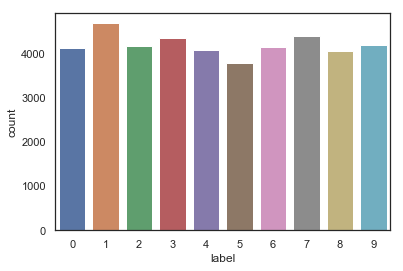

In [9]:
g = sns.countplot(y_train)

In [10]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

### Checking missing values

In [11]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Normalization - grayscale images

In [13]:
X_train = X_train/255.0 # For most images, pixel values are integers that range from 0 (black) to 255 (white)
test = test/255.0

### Reshape

In [14]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

### Label encoding - encode labels to one hot encoding

In [15]:
y_train = to_categorical(y_train, num_classes=10)

In [16]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
y_train.shape

(42000, 10)

### Splitng training and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

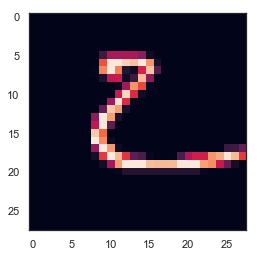

In [19]:
# example
g = plt.imshow(X_train[0][:,:,0])

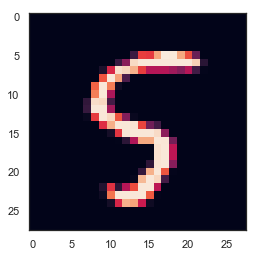

In [23]:
g = plt.imshow(X_train[32000][:,:,0])

## CNN

### Define a model

In [24]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding = 'Same', activation ='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding = 'Same', activation ='relu', input_shape=(28,28,1)))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'Same', activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

### Set the optimizer and annealer

In [26]:
#loss function - categorical crossentropy (a specific form for categorical classification >2 classes)
#optimizer - RMSprop (adjust Adagrad method, faster than Stochastic Gradient Descent optimizer)
#metric - accuracy (similar to the loss function except that the results from the metric evaluation are not used when training the model )

In [27]:
#define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [28]:
#compile the model
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
#set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose =1, 
                                            factor =0.5, 
                                            min_lr = 0.00001)

In [30]:
epochs = 1
batch_size = 86

## Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation i obtained an accuracy of 98.114%
With data augmentation i achieved 99.67% of accuracy

In [32]:
#with data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, #apply ZCA whitening
        rotation_range=10, #randomly rotate images in the range (0 to 180)
        zoom_range = 0.1, # randomly zoom by 10% some training images
        width_shift_range=0.1, #randomly shift images horizontally 10%
        height_shift_range=0.1, #randomly shift images vertically 10%
        horizontal_flip=False,
        vertical_flip=False
) 

In [33]:
datagen.fit(X_train)

In [34]:
#Fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                             epochs=epochs, validation_data = (X_test, y_test),
                             verbose=2, steps_per_epoch = X_train.shape[0] // batch_size,
                             callbacks = [learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 237s - loss: 0.4408 - acc: 0.8589 - val_loss: 0.0756 - val_acc: 0.9752


## Evaluate the model

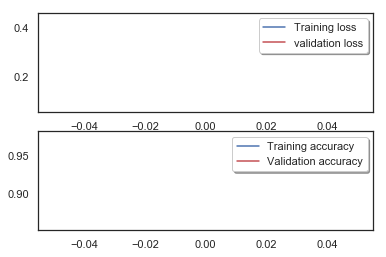

In [35]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [36]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
y_pred = model.predict(X_test)

In [38]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [39]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

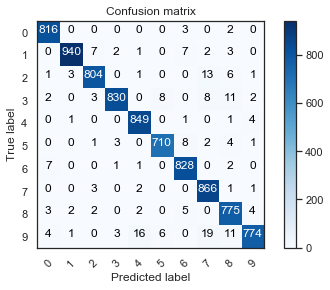

In [40]:
plot_confusion_matrix(confusion_mtx, classes=range(10))